In [1]:
%matplotlib inline

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# some default imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# we will use arviz for some of the plotting
import arviz as az

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

from jax import numpy as jnp, random
from numpyro import sample, handlers
import numpyro.distributions as dist
from numpyro.distributions import (
    Categorical,
    Dirichlet,
    ImproperUniform,
    Normal,
    OrderedLogistic,
    TransformedDistribution,
    constraints,
    transforms,
)
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

# Gaussian regression

We are provided with a set of scores for each candidate, issued by a number of judges over different categories (Originality/Creativity, Importance to the Field, Clarity) with certain confidence. In this simplified model, we will imagine that each judge has actually reported a Gaussian PDF representing a measurement of the true score (plus some bias), with mean given by the reported score and variance inversely proportional to the confidence.

For a given category (say, Clarity), let the score reported for candidate $i$ by judge $j$ be $x_{ij}$ and the uncertainty $\sigma_{ij} \propto {\rm confidence}$. Then, the posterior for the true score $\mu$ of this candidate is, assuming the judges are independent,
$$
p(\mu_i \mid \{x_{ij}, \sigma_{ij} \}_j) = \prod_j p(\mu_i \mid x_{ij}, \sigma_{ij}) \propto \prod_j p(x_{ij} \mid \mu_i, \sigma_{ij}) \, p(\mu_i)
$$
By the Gaussian assumption, let's assume the score of an individual judge is drawn such that 
$$
p(x_{ij} \mid \mu_i, \sigma_{ij}) = \mathcal{N}(\mu_i, \sigma_{ij})[x_{ij}]
$$
Once we specify a prior for the true score $p(\mu_i)$ we are done with this simple model where there is no judge bias. A simple prior could be a uniform distribution, or a Gaussian with mean $\Mu$ and standard deviation $\Sigma$,
$$
p(\mu_i) = \mathcal{N}(\Mu, \Sigma)[\mu_i] \, .
$$

Now, we could also take a look at all candidates simultaneously and consider the possibility that the judges are biased by some amount $\beta_j$. Assume a prior on $\beta_j \sim \mathcal{N}(0, \Beta)$
$$
p(\mu_i \mid \{x_{ij}, \sigma_{ij} \}_{j}, \Beta) \propto \prod_j p(x_{ij} \mid \mu_i, \sigma_{ij}, \Beta) \, p(\mu_i)
$$

Load the ranking data.

In [3]:
# load anonimized data
data = pd.read_csv('ranking_data_anon.csv')
data.iloc[:5]

,Judge,Category,Candidate-0,Candidate-1,Candidate-2,Candidate-3,Candidate-4,Candidate-5,Candidate-6,Candidate-7,...,Candidate-28,Candidate-29,Candidate-30,Candidate-31,Candidate-32,Candidate-33,Candidate-34,Candidate-35,Candidate-36,Candidate-37
0,Judge-0,Orig/ Creat.,6,7,9,9,7,8,8,7,...,7,5,6,7,8,6,9,6,8,7
1,Judge-0,Imp. Field,6,8,9,9,8,7,7,7,...,6,7,6,8,8,7,9,6,8,8
2,Judge-0,Clarity,6,7,9,9,8,8,7,7,...,7,6,6,8,8,7,8,8,8,7
3,Judge-0,Confidence,3,3,1,1,1,2,2,3,...,1,3,3,2,1,3,1,3,2,3
4,Judge-1,Orig/ Creat.,6,7,9,8,7,6,7,6,...,6,7,6,8,8,6,8,6,7,6


In [20]:
Y = jnp.array(data[data['Category'] == 'Orig/ Creat.']['Candidate-0'].values)

n_bins = 10
n_resp = len(data['Judge'].unique())

In [21]:
n_resp

9

### Improper prior with no affinity

We will model the above draws as taken from a categorical process with unknown cut points and measure the location of the cut points. We will start wih an improper uniform prior on the cut points; we will set the affinitiy to zero because it's fully degenerate with the location of the cut points in this case.

In [17]:
def model0a(Y=None, nclasses=n_bins, eta=0):
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    with numpyro.plate("obs", n_resp):
        sample("Y", OrderedLogistic(eta, c_y), obs=Y)

# split prngkey

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)
kernel = NUTS(model0a)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, Y=Y)
mcmc.print_summary()

# get posterior predictive
predictive = numpyro.infer.Predictive(model0a, mcmc.get_samples())
pred = predictive(pred_key)
df_pred = pd.DataFrame(pred['Y'])

sample: 100%|██████████| 1000/1000 [00:01<00:00, 699.11it/s, 31 steps of size 1.79e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    c_y[0]     -3.69      0.92     -3.58     -5.20     -2.33    237.93      1.00
    c_y[1]     -2.11      0.48     -2.09     -2.80     -1.33    353.72      1.00
    c_y[2]     -0.48      0.31     -0.48     -0.97      0.05    781.24      1.00
    c_y[3]      1.57      0.37      1.58      0.91      2.14    622.35      1.01

Number of divergences: 0


We've obtained a range of potential mappings for the cuts in the logistic space:

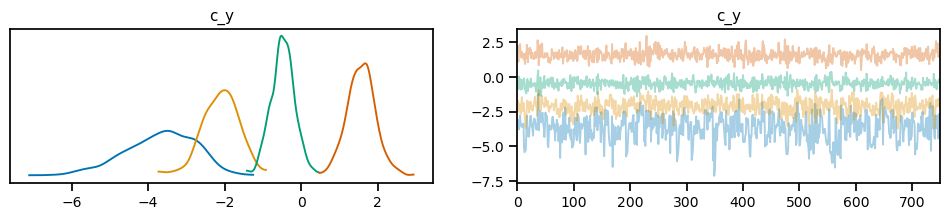

In [18]:
result = az.from_numpyro(mcmc)
az.plot_trace(result);

In [54]:
df_pred_counts = df_pred.apply(lambda x: x.value_counts(), axis=1).fillna(0).astype(int)

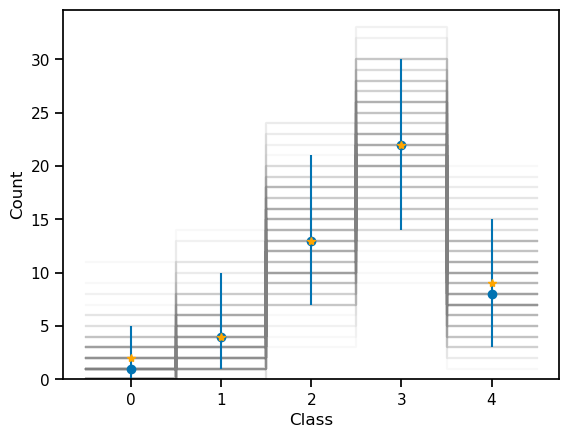

In [53]:
for i, x in df_pred.sample(200).iterrows():
    sns.histplot(x, bins=np.arange(n_bins+1)-0.5, color='gray', alpha=0.05,
                 element='step', fill=False)
    
q = df_pred_counts.quantile([0.05, 0.5, 0.95], axis=0)
plt.errorbar(q.columns, q.loc[0.5], yerr=[q.loc[0.5] - q.loc[0.05], q.loc[0.95] - q.loc[0.5]], fmt='o')

plt.plot(np.arange(n_bins), scores, '*', color='orange', zorder=10)
plt.xlabel('Class');

### Improper prior with affinity

We now check the effect of including an affinity in our model. The affinity parameter $\gamma$ can shift the overall distribution up and down the axis, so it is degenerate with the overall location of the cuts.

#### Uniform affinity prior

We start by setting no prior on the affinity, which will make this problem fully degenerate.

In [56]:
def model0b(Y=None, nclasses=n_bins):
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    gamma = sample(
        "gamma",
        ImproperUniform(
            support=constraints.real,
            batch_shape=(),
            event_shape=(1,),
        ),
    )
    with numpyro.plate("obs", n_resp):
        sample("Y", OrderedLogistic(gamma, c_y), obs=Y)

# split prngkey

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)
kernel = NUTS(model0b)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, Y=Y)
mcmc.print_summary()

# get posterior predictive
predictive = numpyro.infer.Predictive(model0b, mcmc.get_samples())
pred = predictive(pred_key)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 464.90it/s, 1023 steps of size 1.33e-03. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    c_y[0]   1655.05    340.80   1631.61   1152.62   2288.56     11.50      1.13
    c_y[1]   1656.57    340.84   1632.93   1147.64   2282.67     11.50      1.13
    c_y[2]   1658.16    340.80   1634.68   1149.08   2284.17     11.51      1.13
    c_y[3]   1660.21    340.84   1636.61   1150.63   2286.66     11.51      1.13
  gamma[0]   1658.66    340.83   1634.91   1149.86   2284.73     11.51      1.13

Number of divergences: 0


We've obtained a range of potential mappings for the cuts in the logistic space:

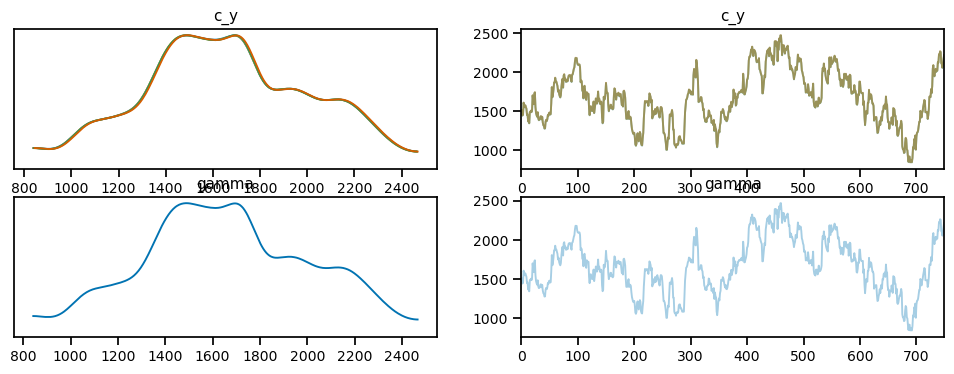

In [57]:
result = az.from_numpyro(mcmc)
az.plot_trace(result);

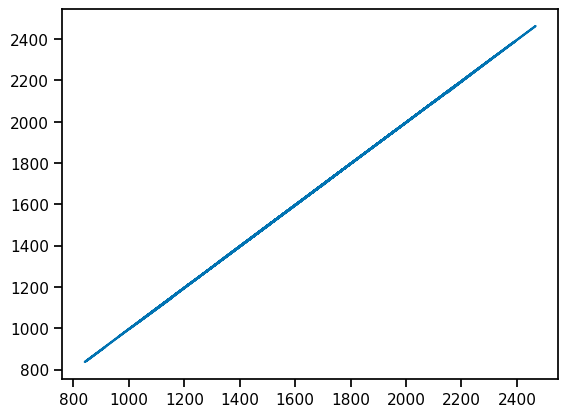

In [58]:
plt.plot(result.posterior["gamma"].values.flatten(), result.posterior["c_y"].values[:,:,0].flatten())

With this setup, the affinity and the cuts are fully degenerate, as we expect.

In [59]:
df_pred = pd.DataFrame(pred['Y'])
df_pred_counts = df_pred.apply(lambda x: x.value_counts(), axis=1).fillna(0).astype(int)

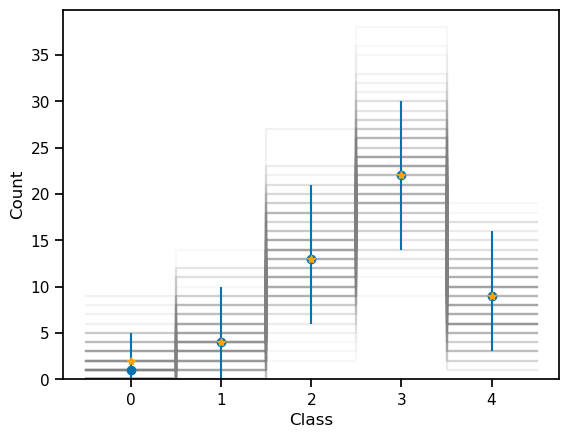

In [60]:
for i, x in df_pred.sample(200).iterrows():
    sns.histplot(x, bins=np.arange(n_bins+1)-0.5, color='gray', alpha=0.05,
                 element='step', fill=False)
    
q = df_pred_counts.quantile([0.05, 0.5, 0.95], axis=0)
plt.errorbar(q.columns, q.loc[0.5], yerr=[q.loc[0.5] - q.loc[0.05], q.loc[0.95] - q.loc[0.5]], fmt='o')

plt.plot(np.arange(n_bins), scores, '*', color='orange', zorder=10)
plt.xlabel('Class');

#### Gausian affinity prior

We can partially anchor the problem by setting a Gaussian prior on the affinity, which will partially break some degeneracies.

In [62]:
def model0b(Y=None, nclasses=n_bins):
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    gamma = sample(
        "gamma",
        Normal(),
    )
    with numpyro.plate("obs", n_resp):
        sample("Y", OrderedLogistic(gamma, c_y), obs=Y)

# split prngkey

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)
kernel = NUTS(model0b)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, Y=Y)
mcmc.print_summary()

# get posterior predictive
predictive = numpyro.infer.Predictive(model0b, mcmc.get_samples())
pred = predictive(pred_key)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 608.62it/s, 31 steps of size 1.44e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    c_y[0]     -3.71      1.42     -3.69     -5.95     -1.42    470.90      1.00
    c_y[1]     -2.16      1.19     -2.21     -3.80      0.00    559.71      1.00
    c_y[2]     -0.54      1.11     -0.54     -2.69      0.95    585.52      1.00
    c_y[3]      1.54      1.12      1.47     -0.30      3.35    588.73      1.00
     gamma     -0.05      1.09     -0.07     -1.84      1.70    586.12      1.00

Number of divergences: 0


We've obtained a range of potential mappings for the cuts in the logistic space:

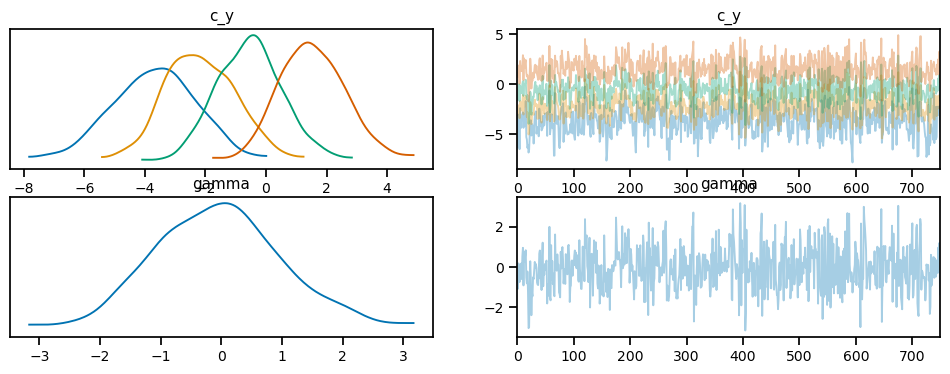

In [63]:
result = az.from_numpyro(mcmc)
az.plot_trace(result);

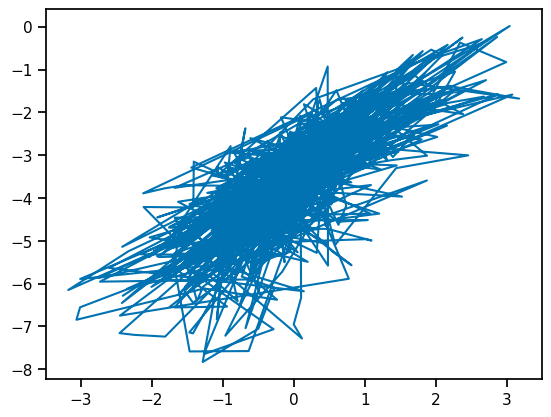

In [64]:
plt.plot(result.posterior["gamma"].values.flatten(), result.posterior["c_y"].values[:,:,0].flatten())

We have broken some of the degeneracy and recovered a result similar to the above with $\gamma = 0$.

In [65]:
df_pred = pd.DataFrame(pred['Y'])
df_pred_counts = df_pred.apply(lambda x: x.value_counts(), axis=1).fillna(0).astype(int)

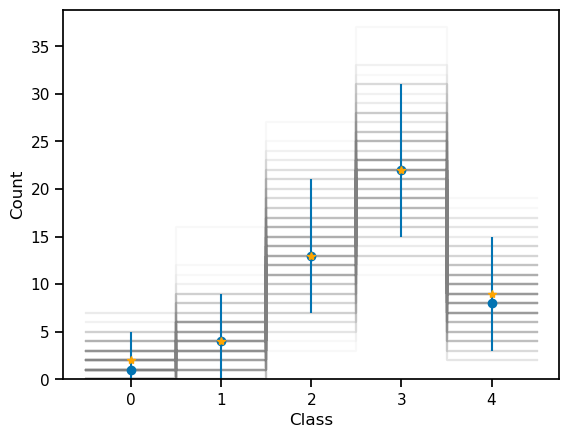

In [66]:
for i, x in df_pred.sample(200).iterrows():
    sns.histplot(x, bins=np.arange(n_bins+1)-0.5, color='gray', alpha=0.05,
                 element='step', fill=False)
    
q = df_pred_counts.quantile([0.05, 0.5, 0.95], axis=0)
plt.errorbar(q.columns, q.loc[0.5], yerr=[q.loc[0.5] - q.loc[0.05], q.loc[0.95] - q.loc[0.5]], fmt='o')

plt.plot(np.arange(n_bins), scores, '*', color='orange', zorder=10)
plt.xlabel('Class');

In [67]:
q

,0,1,2,3,4
0.05,0.0,0.0,7.0,15.0,3.0
0.50,1.0,4.0,13.0,22.0,8.0
0.95,5.0,9.0,21.0,31.0,15.0


### Dirichlet prior

We can repeat the above, but now modeling the histogram as a Dirichlet process.

In [72]:
def model4(Y=None, anchor_point=0.0):
    
    # We will apply a nudge towards equal probability for each category (corresponds to equal logits of the true data generating process)
    concentration = np.ones((n_bins,)) * 10.0

    with handlers.reparam(config={"c_y": TransformReparam()}):
        c_y = sample(
            "c_y",
            TransformedDistribution(
                Dirichlet(concentration),
                transforms.SimplexToOrderedTransform(anchor_point),
            ),
        )
    gamma = sample(
        "gamma",
        ImproperUniform(
            support=constraints.real,
            batch_shape=(),
            event_shape=(1,),
        ),
    )
    with numpyro.plate("obs", n_resp):
        sample("Y", OrderedLogistic(gamma, c_y), obs=Y)


kernel = NUTS(model4)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, Y=Y)
# with exclude_deterministic=False, we will also show the ordinal probabilities sampled from Dirichlet (vis. `c_y_base`)
mcmc.print_summary(exclude_deterministic=False)

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)

# get posterior predictive
predictive = numpyro.infer.Predictive(model4, mcmc.get_samples())
pred = predictive(pred_key)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 581.11it/s, 7 steps of size 5.19e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     c_y[0]     -1.65      0.37     -1.65     -2.29     -1.07    643.73      1.00
     c_y[1]     -0.62      0.31     -0.62     -1.13     -0.13    478.56      1.00
     c_y[2]      0.46      0.29      0.47     -0.01      0.92    425.52      1.00
     c_y[3]      2.02      0.36      2.00      1.44      2.57    573.60      1.00
c_y_base[0]      0.17      0.05      0.16      0.09      0.25    620.13      1.00
c_y_base[1]      0.19      0.05      0.18      0.11      0.27    556.16      1.00
c_y_base[2]      0.26      0.05      0.26      0.18      0.33   1010.78      1.00
c_y_base[3]      0.27      0.05      0.26      0.19      0.35    657.69      1.00
c_y_base[4]      0.12      0.04      0.12      0.06      0.18    543.35      1.00
   gamma[0]      0.88      0.35      0.90      0.31      1.44    419.20      1.00

Number of divergences: 0


In [73]:
df_pred = pd.DataFrame(pred['Y'])
df_pred_counts = df_pred.apply(lambda x: x.value_counts(), axis=1).fillna(0).astype(int)

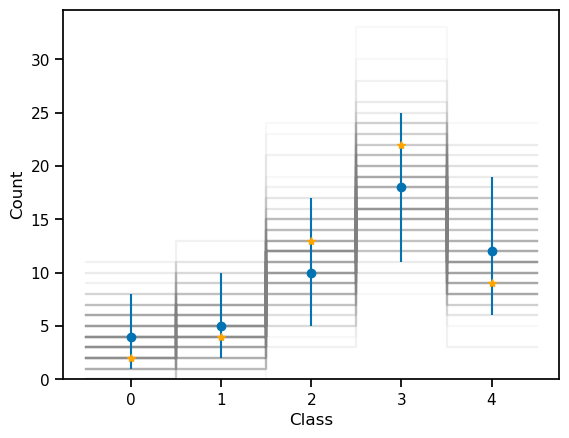

In [74]:
for i, x in df_pred.sample(200).iterrows():
    sns.histplot(x, bins=np.arange(n_bins+1)-0.5, color='gray', alpha=0.05,
                 element='step', fill=False)
    
q = df_pred_counts.quantile([0.05, 0.5, 0.95], axis=0)
plt.errorbar(q.columns, q.loc[0.5], yerr=[q.loc[0.5] - q.loc[0.05], q.loc[0.95] - q.loc[0.5]], fmt='o')

plt.plot(np.arange(n_bins), scores, '*', color='orange', zorder=10)
plt.xlabel('Class');

## Generalized linear regression

Find a correlation between the categorical outcome $Y$ and some predictor variable $X$.
A common application of logistic regression is to find the relationship between the outcomes of $Y$ and some continuous predictor variable $X$. For example, $Y$ could represent different stages of a disease and $X$ a biomarker whose levels correlate with the diseases; in that case, we would want to determine the stage of the disease in the patient given their biomarkers.

Create some data based on the numpyro example for sanity checking. We can generate categorical data using the `Categorical` class in numpro; this will produce categorical draws for a number of bins, with probabilities specified by either a `probs` argument or a `logits` argument, which should be vectors with the same length as the number of bins. Recall that the logit is just an equivalent way of specifying the probability $p$, and it's given by
$$
l \equiv {\rm logit}(p) = \ln\left(\frac{p}{1-p}\right) ;
$$ 
this corresponds to the log odds, i.e., the logarithm of the odds $p /( 1-p)$. The transformation from a set of logits to probabilities is obtained through the _softmax function_,
$$
p_i(\{l_0, \dots , l_{K-1}\}) = \frac{e^l_i}{\sum_{k=0}^{K-1} e^{l_k}} ~ ,
$$
which guarantees that the probabilities are normalized correctly.

In [12]:
simkeys = random.split(random.PRNGKey(1), 2)

n_resp = 50
n_bins = 3

# the Categorical class will draw samples from a categorical distribution
# defined over a set of bins, with probabilities given by the logits argument
Y = Categorical(logits=jnp.zeros(n_bins)).sample(simkeys[0], sample_shape=(n_resp,))

# create corresponding noisy observations in the latent space of X by sampling
# from a Normal distribution
X = Normal().sample(simkeys[1], sample_shape=(n_resp,))
X += Y

print("value counts of Y:")
df = pd.DataFrame({"X": X, "Y": Y})
print(df.Y.value_counts())

for i in range(n_bins):
    print(f"mean(X) for Y == {i}: {X[jnp.where(Y==i)].mean():.3f}")

value counts of Y:
Y
0    19
2    17
1    14
Name: count, dtype: int64
mean(X) for Y == 0: 0.462
mean(X) for Y == 1: 1.077
mean(X) for Y == 2: 1.856


In [13]:
Y

Array([1, 1, 2, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 2, 2, 1, 0,
       0, 0, 0, 2, 1, 2, 0, 1, 0, 1, 0, 2, 2, 0, 1, 1, 0, 0, 1, 2, 0, 0,
       0, 0, 2, 2, 2, 1], dtype=int64)

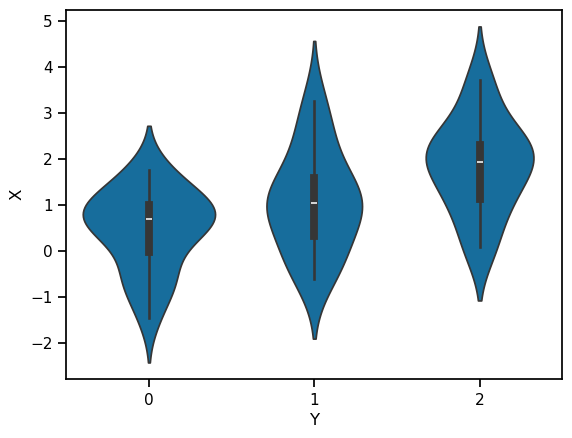

In [5]:
sns.violinplot(x="Y", y="X", data=df);

In [54]:
# df = pd.read_csv('ranking_data_anon.csv', index_col=None)
# df[df['Category'] == 'Clarity']['Candidate-0']

In [57]:
def model1(X, Y, nclasses=3):
    b_X_eta = sample("b_X_eta", Normal(0, 5))
    c_y = sample(
        "c_y",
        ImproperUniform(
            support=constraints.ordered_vector,
            batch_shape=(),
            event_shape=(nclasses - 1,),
        ),
    )
    with numpyro.plate("obs", X.shape[0]):
        eta = X * b_X_eta
        sample("Y", OrderedLogistic(eta, c_y), obs=Y)


mcmc_key = random.PRNGKey(1234)
kernel = NUTS(model1)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750)
mcmc.run(mcmc_key, X, Y, n_bins)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:01<00:00, 585.00it/s, 7 steps of size 4.27e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_X_eta      1.07      0.27      1.06      0.63      1.50    419.55      1.00
    c_y[0]      0.48      0.38      0.47     -0.15      1.06    459.36      1.00
    c_y[1]      2.06      0.47      2.02      1.22      2.73    447.09      1.00

Number of divergences: 0
